# Exercises for Bayesian Statistics

The following script is the solution the exercises for the probability theory section (ie. the exercises 12-16) of the course 'Statistics for Data Science' (WS 19/20) by Prof. Ostwald. The exercise sheets can be found at the website https://www.ewi-psy.fu-berlin.de/einrichtungen/arbeitsbereiche/computational_cogni_neurosc/teaching/Statistics_for_Data_Science_19_20.html.

## Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# For reproducibility, fix seed.
np.random.seed(42)

## 12. Foundations and Conjugate Inference

### 1. Batch vs. Recursive Bayesian Estimation for Beta-Binomial Model

For the beta-binomial model, we'll have three steps:

1) Choose Prior: Choose beta distribution $P(\theta)$.

2) Likelihood: Generate Data with binomial distribution, $P(x|\theta)$.

3) Make Posterior. $P(\theta|x) \propto P(x|\theta) P(\theta)$.

Then, the comparison batch vs. recursive is made.

In [3]:
from scipy.stats import binom, beta, bernoulli

#### 1. Prior

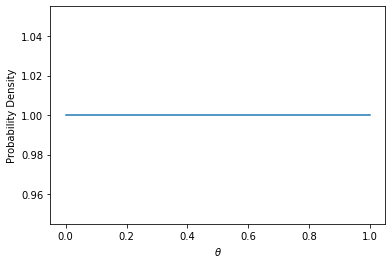

In [4]:
theta_range = np.linspace(0, 1, 1000)
theta_range_plus_eps = theta_range + 0.001
a = 1
b = 1

# Visualization.
prior = beta.pdf(x = theta_range, a = a, b = b)
plt.plot(theta_range, prior)
plt.xlabel(r"$\theta$")
plt.ylabel('Probability Density')

# Taking difference of cdfs as we need to have probability (here PMF)
# not the density given by beta.pdf for further calculations.
prior = beta.cdf(x = theta_range_plus_eps, a = a, b = b) - beta.cdf(x = theta_range, a = a, b = b) 

#### 2. Likelihood

In [5]:
# Generate data
n = 10
theta_unknown = 0.3
n_pos = np.random.binomial(n, theta_unknown)
n_pos

2

Text(0, 0.5, 'Probability')

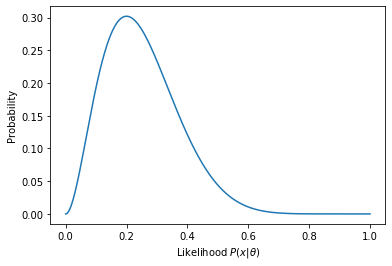

In [6]:
likelihood = binom.pmf(k = n_pos, n = n, p = theta_range) 
plt.plot(theta_range, likelihood)
plt.xlabel(r"Likelihood $P(x|\theta)$")
plt.ylabel("Probability")

#### 3. Posterior

In [7]:
posterior = likelihood * prior 
normalized_posterior = posterior / np.sum(posterior)

0.20020020020020018


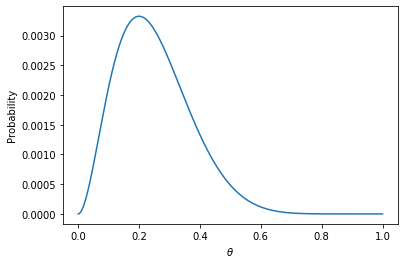

In [15]:
plt.plot(theta_range, normalized_posterior)
plt.xlabel(r"$\theta$")
plt.ylabel("Probability")
print(theta_range[np.argmax(posterior)])

However, we can also use the fact that we know the posterior will be also a beta distribution (as beta is the conjugate prior in this case). This yields the following for comparing batch and recursive bayesian estimation:

#### Batch vs. Recursive Estimation

In [9]:
n = 10
sample = bernoulli.rvs(theta_unknown, size = n)
n_pos = sample.sum()

prior = beta.pdf(x = theta_range, a = a, b = b)
posterior_batch = beta.pdf(x = theta_range, a = a + n_pos, b = b + n)

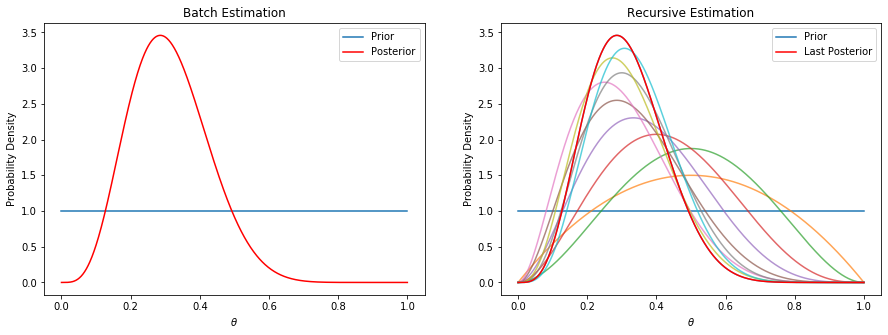

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5), sharex=True)

for ax in axs:
    ax.plot(theta_range, prior, label = "Prior")
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel('Probability Density')
    

# Batch
axs[0].set_title("Batch Estimation")
axs[0].plot(theta_range, posterior_batch, color = 'red', label = "Posterior")

# Recursive
axs[1].set_title("Recursive Estimation")
for num, i in enumerate(sample):
    a = a + i
    b = b + 1
    posterior_batch = beta.pdf(x = theta_range, a = a, b = b)
    axs[1].plot(theta_range, posterior_batch, alpha = 0.7)
    if num == n-1:
        axs[1].plot(theta_range, posterior_batch, color = 'red', label = 'Last Posterior')

axs[0].legend()
axs[1].legend()

plt.legend();

#### Observation

You can see with the recursive estimation that the prior we started with is taken less and less into account. The new prior is the previous posterior!
As expected, the recursive and batch Bayesian estimation yield the same result when all samples are taken into account.

### 2. Bias and Consistency Properties of the Posterior Expected Value (Beta-Binomial Model)

### 3. Bias and Consistency Properties of the Posterior Expected Value (Gaussian-Gaussian Model)